In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import os 
import time 
from tqdm import tqdm_notebook

In [3]:
os.getcwd()

'/content'

In [0]:
os.chdir('/content/drive/My Drive/MachineLearning/cat_images/')

In [6]:
image_files = os.listdir()
len(image_files)

53

### General description

While building an image search engine, the first step is to index the dataset. Indexing refers to the process of quantifying the data by utilizing an image descriptor to extract features from eache image.

Input image ---> Image Descriptor ---> Feature vector

The feature vectors generated can then be compared for similarity using a distance metric or similarity function. The distance metric function take two image feature vectors as inputs and outputs a number that determines how similar they are. 

### Step 1 : Defining the image descriptor 

In [0]:
# Define image descriptor

import imutils 

class ColorDescriptor:
	def __init__(self, bins):
		# store the number of bins for the 3D histogram 
		self.bins = bins 

	def describe(self, image):
		# convert the image to the HSV color space and initialize
		# the features used to quantify the image
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		features = []

		# grab the dimensions and compute the center of the image
		(h, w) = image.shape[:2]
		(cX, cY) = (int(w * 0.5), int(h * 0.5))

		# divide the image into four rectangles/segments (top-left,
		# top-right, bottom-right, bottom-left)
		segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
			(0, cX, cY, h)]

		# construct an elliptical mask representing the center of the
		# image
		(axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
		ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
		cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

		# loop over the segments
		for (startX, endX, startY, endY) in segments:
			# construct a mask for each corner of the image, subtracting
			# the elliptical center from it
			cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
			cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
			cornerMask = cv2.subtract(cornerMask, ellipMask)

			# extract a color histogram from the image, then update the
			# feature vector
			hist = self.histogram(image, cornerMask)
			features.extend(hist)

		# extract a color histogram from the elliptical region and
		# update the feature vector
		hist = self.histogram(image, ellipMask)
		features.extend(hist)

		return features 

	def histogram(self, image, mask):
		# extract a 3D color histogram from the masked region of the
		# image, using the supplied number of bins per channel
		hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
			[0, 180, 0, 256, 0, 256])
 
		# normalize the histogram if we are using OpenCV 2.4
		if imutils.is_cv2():
			hist = cv2.normalize(hist).flatten()
 
		# otherwise handle for OpenCV 3+
		else:
			hist = cv2.normalize(hist, hist).flatten()
 
		# return the histogram
		return hist
		

### Step 2: Extracting features

In [9]:
cd = ColorDescriptor((8,12,3))    # ColorDescriptor object

output = open("image_index.csv", "w")    # this file will contain the image ID along with the feature vector

for img in tqdm_notebook(image_files) :
  try:
    imageID = img 
    image = cv2.imread(img)
    features = cd.describe(image)

    features = [str(f) for f in features]
    output.write("%s,%s\n" % (imageID, ",".join(features)))
  except Exception as e:
    continue
output.close()

### Step 3: Searching for similarity

Now that we have extracted features from the images, we need a method to compare these features to find similarity. We define a class that will perform the search using a similarity metric



In [0]:
class Searcher:
	def __init__(self, indexPath):
		# store our index path
		self.indexPath = indexPath
 
	def search(self, queryFeatures, limit = 5):
		# initialize our dictionary of results
		results = {}

		with open(self.indexPath) as f:
			# initialize the CSV reader
			reader = csv.reader(f)
			for row in reader:
				features = [float(x) for x in row[1:]]
				d = self.chi2_distance(features, queryFeatures)

				results[row[0]] = d

			f.close()

		results = sorted([(v, k) for (k, v) in results.items()])

		return results[:limit]

	def chi2_distance(self, histA, histB, eps = 1e-10):
		# compute the chi-squared distance
		d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
			for (a, b) in zip(histA, histB)])
 
		# return the chi-squared distance
		return d

### Perform search to find similar images 

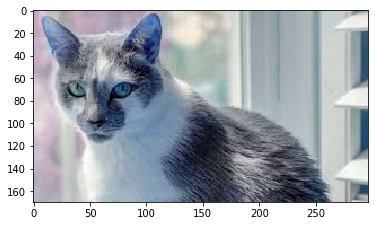

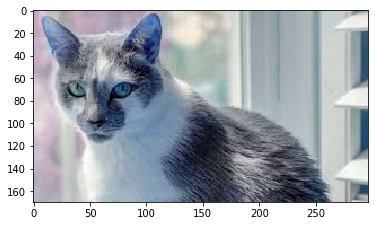

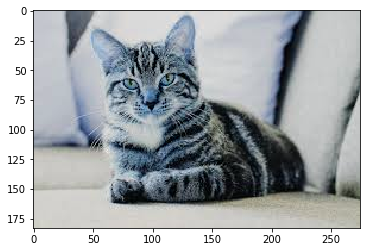

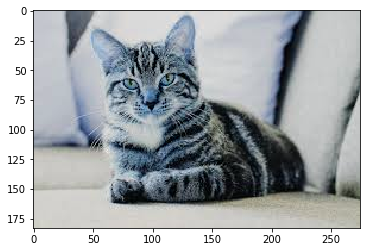

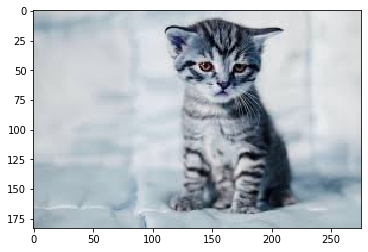

In [14]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

import csv

cd = ColorDescriptor((8,12,3))

query = cv2.imread(image_files[10])    # query image
features = cd.describe(query) 

searcher = Searcher("/content/drive/My Drive/MachineLearning/cat_images/image_index.csv")
results = searcher.search(features)

result_list = []
for (score, resultID) in results :
  result = cv2.imread(resultID)
  result_list.append(result)
  plt.figure()    
  plt.imshow(result)

### First picture is the query picture and the subsequent pictures are the similar pictures
